# CUARTO INFORME DE ASTROMETRIA
#### Baracchi, Marcos. Gmail: marcos.baracchi@mi.unc.edu.ar

### **1_Introducción**

### **2_Datos y Resultados**  

#### **2.1_Ejercicio 1** 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

Los datos utilizados en el trabajo se fueron tomados del paper de Balton et al. (2001), del cual se tomaron la magnitudes de las galaxias(M/$ Mpc^3 $), la luminosidad (galaxias/$ Mpc^3 $), y su correspondiente error superior e inferior de este ultimo.

In [2]:
df = pd.read_csv("datos.csv") #cargamos y visualisamos los datos
df.head()

,MAG,PHI,error_inf,error_sup
0,-23.183,0.000003,0.000001,0.000006
1,-23.020,0.000005,0.000003,0.000011
2,-22.870,0.000017,0.000013,0.000026
3,-22.698,0.000035,0.000025,0.000044
4,-22.565,0.000082,0.000058,0.000105


A continuación, se graficaron los datos con su correspondiste error.

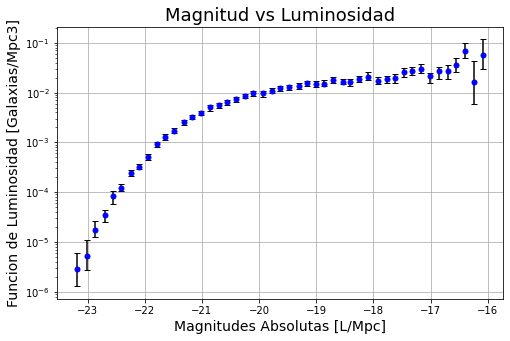

In [3]:
plt.figure(figsize=(8,5))
error_s =  df['error_sup'] - df['PHI']
error_i =  -df['error_inf'] + df['PHI']
plt.errorbar(df['MAG'], df['PHI'],  yerr = [error_i,error_s], fmt='ob',ms = 5,  capsize=3,  ecolor="k")
plt.xlabel('Magnitudes Absolutas [L/Mpc]',fontsize = 14) 
plt.ylabel('Funcion de Luminosidad [Galaxias/Mpc3]',fontsize = 14)
plt.yscale('log')
plt.grid()
plt.title('Magnitud vs Luminosidad',fontsize = 18 )
plt.show()

#### **2.2_Ejercicio 2** 

Luego, se uso la funcion *Schechter* para modelar la curva visualizada anteriormente, la cual es funcion de la magnitud M y **depende de tres parametros** $ \phi_0 $, $ \alpha $ y $ M_0 $.

$$ \phi(M)dM = 0.4\log(10)\phi_010^{-0.4(M-M_0)(\alpha + 1)}\times\exp(-10^{-0.4(M-M_0)})dM $$

Se realizará una inferencia Bayesiana para obtener el ajuste del modelo paramétrico a los datos, que como el nombre lo indica, la inferencia estadı́stica se lleva a cabo como una aplicación del teorema de Bayes.

Si se tiene un conjunto de datos *d* que se puede describir por un modelo *m* con parámetros $\phi $, se quiere calcular el mejor modelo que puede dar lugar a esos datos, es decir, maximizar la probabilidad posterior de los parámetros dados los datos para un modelo, $ p(\phi|m,d) $. Ésta probabilidad se puede escribir gracias al Teorema de Bayes, como:

$$ p(\phi|m,d) = \frac{p(d|m,\phi)p(\phi|m)}{p(d|m)} $$

donde $ p(d|m,\phi) $ es el Likelihood, $ p(\phi|m) $  la función distribución de la probabilidad anterior (prior) y $p(d|m)$ la evidencia. Donde la *prior* se toma igual a 1 ya que el modelo esta fijo y la evidencia tambien por conveniencia.

In [4]:
def schechter(M,phi0,a0,M0): # defino la funcion schecheter
    lista = []
    for i in range(len(M)):
        p = 10**((-0.4*(M[i] - M0))*(a0 + 1))
        r = np.exp(-10**(-0.4*(M[i] -M0 )))
        y =y=0.4 * np.log(10) * phi0 * p * r
        lista.append(y)
    return(lista)

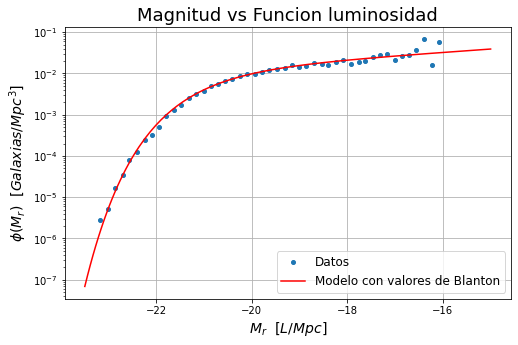

In [5]:
plt.figure(figsize=(8,5))
plt.plot(df['MAG'],df['PHI'],'o',label = 'Datos',ms = 4)
sx = np.linspace(-23.5, -15, 150)
sy = schechter(sx,0.0146,-1.20,-20.83) # estos valores son los obtenidos de Blanton et al. (2001).
plt.plot(sx,sy, color='red', label='Modelo con valores de Blanton')
plt.xlabel('$ M_r $  $[L/Mpc]$',fontsize = 14); plt.ylabel('$\phi(M_r)$  $[Galaxias/Mpc^3]$',fontsize = 14)
plt.yscale('log')
plt.grid()
plt.title('Magnitud vs Funcion luminosidad',fontsize = 18 )
plt.legend(loc = 'lower right',fontsize = 12)
plt.show()

Los parámetros que se intentan determinar son $ \phi_0 $, $ \alpha $ y $ M_0 $. Para ello, se definieron primero las siguientes funciones:
- la función de ***likelihood*** $ \rightarrow $ mide la discripancia entre los valores de los datos y el modelo.
- la función de ***priors*** $ \to $ es el espacio de parametros en donde realizaremos la busqueda de estos.
- la función de ***probabilidad posterior*** $\to $ es la probabilidad de los datos dado el modelo $ p(\phi_i|m) $.

Antes, definimos los errores de los tados, ya que vamos a suponer que los mismos soy gaussianos, donde los datos estan centrados en la gaussiana. Hacemos esta suposición de los errores ya que este modo el calculo de el *likelihood* se tranforma en una expresión mas sencilla.

In [6]:
error_s =  df['error_sup'] - df['PHI']
error_i =  -df['error_inf'] + df['PHI']
sigma = np.abs((error_s - error_i)/2)

In [7]:
def likelihood(M,phi,phi0,a0,M0,sigma):
    phi_model = schechter(M,phi0,a0,M0) # valor de phi calculado por el modelo 
    c = 1/(np.sqrt(2*np.pi)*sigma)
    w = c*((phi - phi_model))**2/((np.sqrt(2)*sigma))**2
    p = np.sum(w)/100000000 #esto para q me queden mas chicos los valores
    return(p)

In [8]:
def priors(phi0,a0,m0,philim,Alim,Mlim):
    if (philim[0]<= phi0) & (phi0 <= philim[1]) & (a0 >= Alim[0]) & (a0 <= Alim[1]) & (Mlim[0]<= m0) & (Mlim[1]>= m0):
        return 1 
    else:
        return 0 

In [9]:
def posteriori (m,f,phi0,a0,m0,sigma,philim,Alim,Mlim): # esto es el log de la posteriori
    post = likelihood(m,f,phi0,a0,m0,sigma) + np.log(priors(phi0,a0,m0,philim,Alim,Mlim))
    return (post)

Luego, para definir el espacio de parametros vamos a ver como estos afectan al modelo y lo vamos a realizar de manera grafica.

In [10]:
fi0 = np.linspace(0.001,0.040,10)
A0 = np.linspace(-3,0.,10)
m0 = np.linspace(-23,-19,10)
p = []
o = []
q = []
for i in range(10):        
    g = schechter(sx,fi0[i], -1.20, -20.83) # tengo q cambiar el likelihood por la schechter
    l = schechter(sx,0.0146, A0[i], -20.83)
    m = schechter(sx,0.0146, -1.20, m0[i])
    p.append(g)
    o.append(l)
    q.append(m)

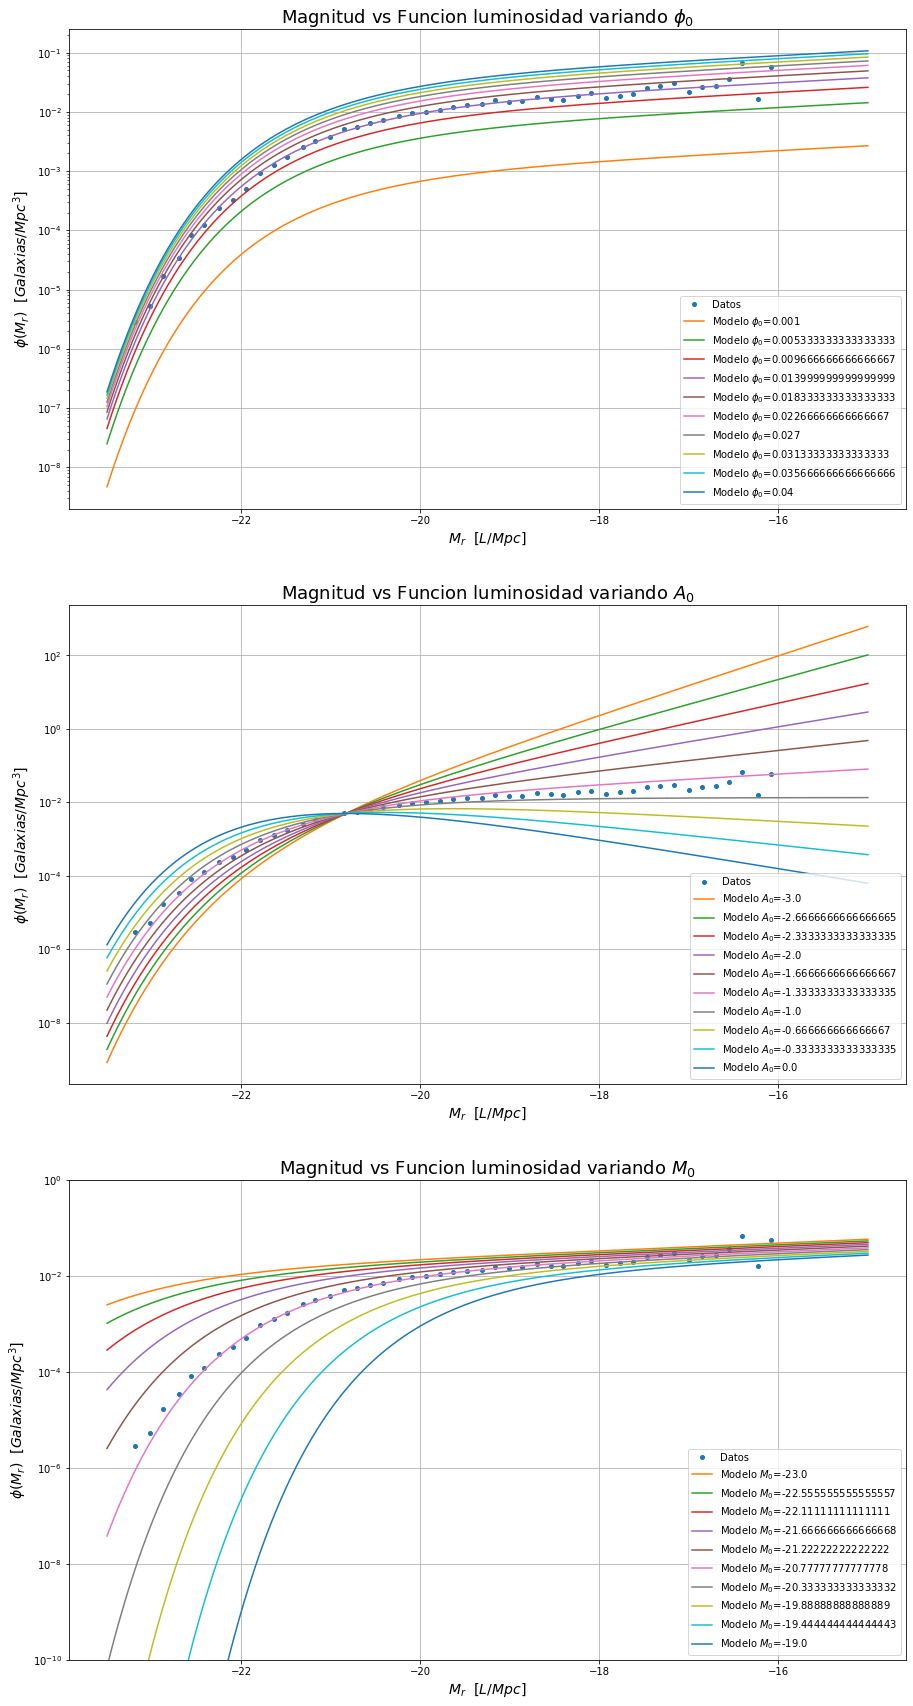

In [11]:
plt.figure(figsize=(15,30))
sx = np.linspace(-23.5, -15, 150)
#sy = schechter(sx,0.0146,-1.20,-20.83) # estos valores son los obtenidos de Blanton et al. (2001).

plt.subplot(3,1,1)
plt.plot(df['MAG'],df['PHI'],'o',label = 'Datos',ms = 4)
for i in range(10):
    plt.plot(sx,p[i], label=f"Modelo $ \phi_0$={fi0[i]}")
plt.xlabel('$ M_r $  $[L/Mpc]$',fontsize = 14); plt.ylabel('$\phi(M_r)$  $[Galaxias/Mpc^3]$',fontsize = 14)
plt.yscale('log')
plt.grid()
plt.title('Magnitud vs Funcion luminosidad variando $\phi_0$',fontsize = 18 )
plt.legend(loc = 'best')

plt.subplot(3,1,2)
plt.plot(df['MAG'],df['PHI'],'o',label = 'Datos',ms = 4)
for i in range(10):
    plt.plot(sx,o[i], label=f"Modelo $ A_0 $={A0[i]}")
plt.xlabel('$ M_r $  $[L/Mpc]$',fontsize = 14); plt.ylabel('$\phi(M_r)$  $[Galaxias/Mpc^3]$',fontsize = 14)
plt.yscale('log')
plt.grid()
plt.title('Magnitud vs Funcion luminosidad variando $ A_0$',fontsize = 18 )
plt.legend(loc = 'lower right')

plt.subplot(3,1,3)
plt.plot(df['MAG'],df['PHI'],'o',label = 'Datos',ms = 4)
for i in range(10):
    plt.plot(sx,q[i], label=f"Modelo $ M_0$={m0[i]}")
plt.xlabel('$ M_r $  $[L/Mpc]$',fontsize = 14); plt.ylabel('$\phi(M_r)$  $[Galaxias/Mpc^3]$',fontsize = 14)
plt.yscale('log')
plt.ylim(0.0000000001,1)
plt.grid()
plt.title('Magnitud vs Funcion luminosidad variando $M_0$',fontsize = 18 )
plt.legend(loc = 'best')

plt.show()

De estos graficos obtenemos los limites de los parametros. Se decidieron tomar los siguientes valores:

In [12]:
philim = [0.005,0.035]
Alim = [-1.66,-0.66]
Mlim = [-21.22,-20.33]

Ya que estos valores para los parametros encierran a todos los puntos de datos.

In [13]:
#Ahora, realizamos un grafico de contorno para ver la relacion entre los parametros y que tenemos que esperar a la hora de recorrer este espacio.

In [14]:
#fi0c = np.linspace(0.005,0.035,10)
#A0c = np.linspace(-1.66,-0.66,10)
#m0c = np.linspace(-21.22,-20.33,10)
#hc1 = []
#hc2 = []
#hc3 = []
#plt.figure(figsize =(20,10))
#plt.subplot(1,3,1)
#for i in range(10):    
#    hc = []
#    for j in range(10):
#        g = posteriori (df['MAG'],df['PHI'],0.0146,A0c[i],m0c[j],sigma,philim,Alim,Mlim)
#        hc.append(g)
#    hc1.append(hc)
#plt.contour(A0c,m0c,hc1,levels = 10)
#plt.colorbar()
#plt.title(' $A_0 vs M_0 $')
#
#plt.subplot(1,3,2)
#for i in range(10):    
#    hc = []
#    for j in range(10):
#        g = posteriori (df['MAG'],df['PHI'],fi0c[i],-1.20,m0c[j],sigma,philim,Alim,Mlim)
#        hc.append(g)
#    hc2.append(hc)
#plt.contour(fi0c,m0c,hc2,levels = 10)
#plt.colorbar()
#plt.title(' $\phi_0 vs M_0 $')
#    
#plt.subplot(1,3,3)
#for i in range(10):    
#    hc = []
#    for j in range(10):
#        g =  posteriori (df['MAG'],df['PHI'],fi0c[i],A0c[j],-20.83,sigma,philim,Alim,Mlim)
#        hc.append(g)
#    hc3.append(hc)
#plt.contour(fi0c,A0c,hc3,levels = 10)
#plt.colorbar()
#plt.title(' $\phi_0 vs A_0 $')
#plt.show()

Si tode esta correctamente, la funcions postiriori deberia presentar un minimo(por construccion de la funcion likelihood) en los valores obtenidos por Baltom. Veamos si eso sucede.

In [15]:
#plt.subplot?

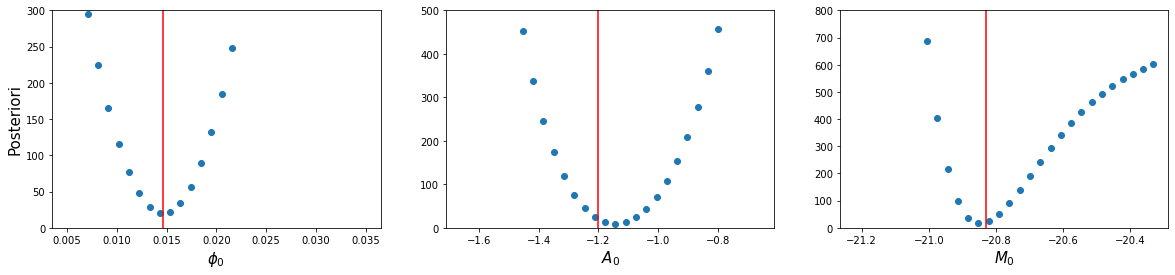

In [16]:
fi0c = np.linspace(0.005,0.035,30)
A0c = np.linspace(-1.66,-0.66,30)
m0c = np.linspace(-21.22,-20.33,30)
a = []
b = []
c = []
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
for i in range(30):
    a.append(posteriori (df['MAG'],df['PHI'],fi0c[i],-1.2,-20.83,sigma,philim,Alim,Mlim))
plt.plot(fi0c,a,'o')
plt.plot([0.0146,0.0146], [-50,350],color="red")
plt.ylim(0,300)
plt.xlabel('$\phi_0$',fontsize = 15)
plt.ylabel('Posteriori',fontsize = 15)

plt.subplot(1,3,2)
for i in range(30):
    b.append(posteriori (df['MAG'],df['PHI'],0.0146 ,A0c[i],-20.83,sigma,philim,Alim,Mlim))
plt.plot(A0c,b,'o')
plt.plot([-1.20,-1.20], [-100,600],color="red")
plt.ylim(0,500)
plt.xlabel('$A_0$',fontsize = 15)

plt.subplot(1,3,3)
for i in range(30):
    c.append(posteriori (df['MAG'],df['PHI'],0.0146,-1.2,m0c[i],sigma,philim,Alim,Mlim))
plt.plot(m0c,c,'o')
plt.plot([-20.83,-20.83], [-100,1100],color="red")
plt.ylim(0,800)
plt.xlabel('$M_0$',fontsize = 15)

plt.show()

Vemos que en general sucede lo que esperabamos. En el caso de $ \alpha_0 $ encontremos una pequeña discrepancia, por lo que le prestaremos mas atencion a este parametro mas adelante.

Una ves que tenemos las funciones definidas y probadas, junto con en espacio de parametros a estudiar, vamos a definir una función del algoritmo de **Metrópolis-Hastings** para luego recorrer el espacio de parametros y encontrar los mejores valores.

In [17]:
def metropolis(m,f,phi0,a0,m0,N,philim,Alim,Mlim,sigma): #aca los phi0,a0 y m0 son valores iniciales 
 #de donde va a comensar el algoritmo
    param = np.zeros((N,3))
    if priors(phi0,a0,m0,philim,Alim,Mlim) == 1:
        param[0][0],param[0][1],param[0][2] = phi0,a0,m0
    else:
        return ('Los parametros no estan dentro de los valores permitidos')
    poste = []
    rl = []
    for i in range(N-1):
        h = posteriori (m,f, param[i][0],param[i][1],param[i][2],sigma,philim,Alim,Mlim)
        poste.append(h)
        param[i+1][0] = param[i][0] + ((np.random.rand()*2.0)-1.0)*((philim[1]-philim[0])/50)
        param[i+1][1] = param[i][1] + ((np.random.rand()*2.0)-1.0)*((Alim[1]-Alim[0])/50)
        param[i+1][2] = param[i][2] + ((np.random.rand()*2.0)-1.0)*((Mlim[1]-Mlim[0])/50)      
        #
        if priors(param[i+1][0],param[i+1][1],param[i+1][2],philim,Alim,Mlim) == 1:
            k = posteriori (m,f, param[i+1][0],param[i+1][1],param[i+1][2],sigma,philim,Alim,Mlim)
            r = h-k
            rl.append(r)  
        #r = np.exp(r)           
            if r >= 0:
                continue #acepto derecho
            else:
                r = np.exp(r)
                random = np.random.random()
                #print(r,random)
                if random < r:
                    #print('Acepta')
                    continue
                else:
                    #print('No Acepta')
                    param[i+1][0] = param[i][0] 
                    param[i+1][1] = param[i][1]
                    param[i+1][2] = param[i][2]
        else:
            param[i+1][0] = param[i][0] 
            param[i+1][1] = param[i][1]
            param[i+1][2] = param[i][2]
    return(poste,rl,param)

Y ahora, vamos a realizar una caminata para visualizar a que regiones del espacio converge la cadena, donde los puntos de partida de la cadena se tomaron de forma arbitrarea.

In [18]:
#philim = [0.005,0.035]
#Alim = [-1.66,-0.66]
#Mlim = [-21.22,-20.33]
#plt.subplot_mosaic?

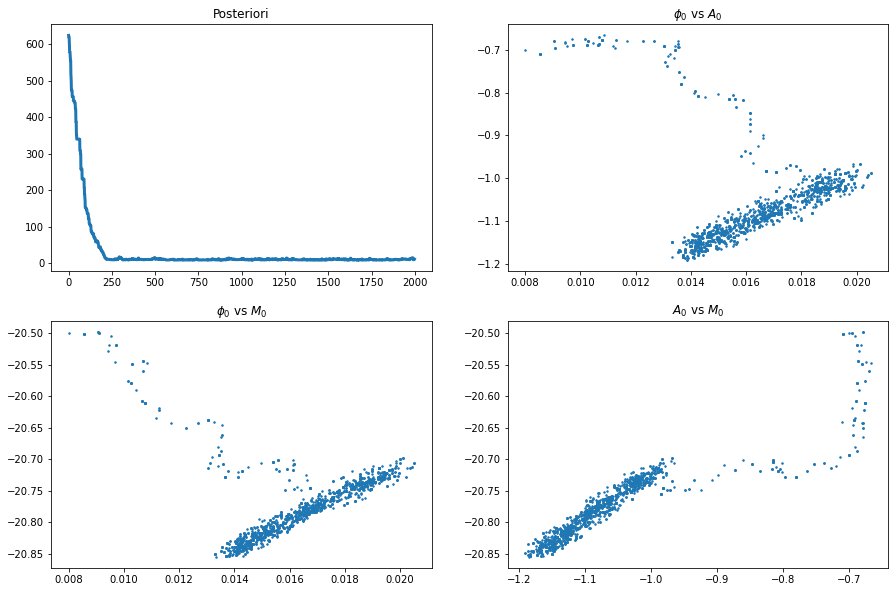

In [35]:
pos = metropolis(df['MAG'],df['PHI'],0.008,-0.7,-20.5,2000,philim,Alim,Mlim,sigma)[0]
par = metropolis(df['MAG'],df['PHI'],0.008,-0.7,-20.5,2000,philim,Alim,Mlim,sigma)[2]

plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(pos,'-',lw = 3)
plt.title('Posteriori')

plt.subplot(2,2,2)
plt.plot(par[:,0],par[:,1],'.',ms = 3)
plt.title('$\phi_0$ vs $A_0 $')

plt.subplot(2,2,3)
plt.plot(par[:,0],par[:,2],'.',ms = 3)
plt.title('$\phi_0$ vs $M_0 $')

plt.subplot(2,2,4)
plt.plot(par[:,1],par[:,2],'.',ms = 3)
plt.title('$A_0$ vs $M_0 $')

plt.show()

Podemos hacer el **promedio** y la **desviacion estandar** de los parametros obtenidos **desde el paso 500** en adelante.

In [38]:
phi0_mean = np.mean(par[500:,0])
phi0_desv = np.std(par[500:,0])
a0_mean = np.mean(par[500:,1])
a0_desv = np.std(par[500:,1])
M0_mean = np.mean(par[500:,2])
M0_desv = np.std(par[500:,2])
print('phi0_mean=',phi0_mean,'phi0_desv=',phi0_desv)
print('a0_mean=',a0_mean,'a0_desv=',a0_desv)
print('M0_mean=',M0_mean,'M0_desv=',M0_desv)


phi0_mean= 0.016092312524925382 phi0_desv= 0.0017450927541805242
a0_mean= -1.100956956229108 a0_desv= 0.05156760703624221
M0_mean= -20.795101929379687 M0_desv= 0.03837342159213726


Si ahora realizamos varias caminatas en simultaneo, partiendo desde puntos aleatorios tendiamos que ver que todas las cadenas convergen a un mismo punto (region, dado que no van directamente hacia en minimo si no que pueden recorrer el espacio de parametros).

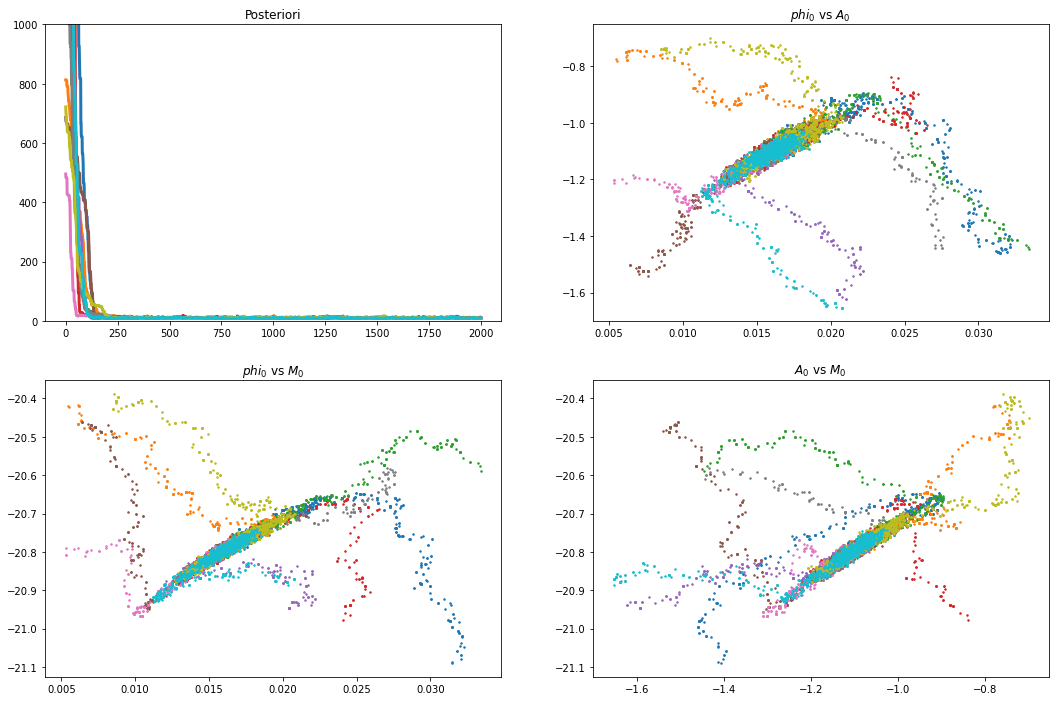

In [21]:
philim = [0.005,0.035]
Alim = [-1.66,-0.66]
Mlim = [-21.22,-20.33]
plt.figure(figsize = (18,12))
for i in range(10):
    fi0 = np.random.random()*0.030+0.005
    a0 = np.random.random()*1-1.66
    m0 = np.random.random()*0.89-21.22
    pos = metropolis(df['MAG'],df['PHI'],fi0,a0,m0,2000,philim,Alim,Mlim,sigma)[0]
    par = metropolis(df['MAG'],df['PHI'],fi0,a0,m0,2000,philim,Alim,Mlim,sigma)[2]
    
    plt.subplot(2,2,1)
    plt.plot(pos,'-',lw = 3)
    plt.ylim(0,1000,200)
    plt.title('Posteriori')    
    
    plt.subplot(2,2,2)
    plt.plot(par[:,0],par[:,1],'.',ms = 3)
    plt.title('$phi_0$ vs $A_0$ ')
    
    plt.subplot(2,2,3)
    plt.plot(par[:,0],par[:,2],'.',ms = 3)
    plt.title('$phi_0$ vs $M_0$ ')
       
    plt.subplot(2,2,4)
    plt.plot(par[:,1],par[:,2],'.',ms = 3)
    plt.title('$A_0$ vs $M_0$ ')
    
plt.show()

Si ahora dividimos los intervalos de cada uno de los parametros en 2 partes y tomando el valor central de cada unos de esos sub intervalos vamos a tener 8 cadenas que comenzaran de puntos seleccionados.

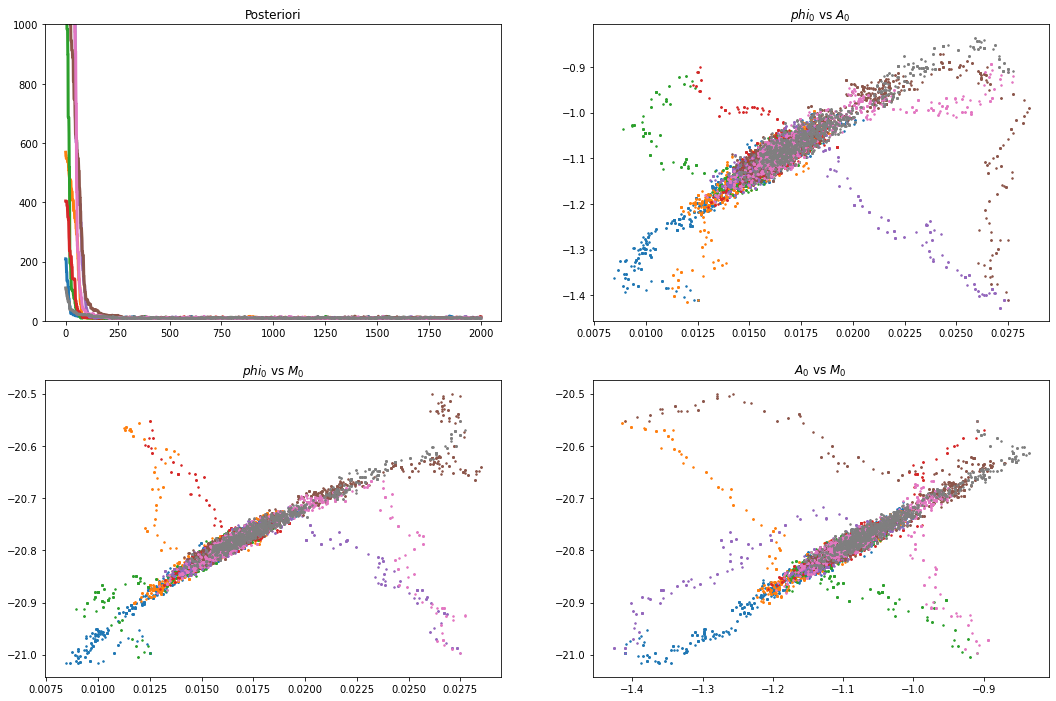

In [22]:
philim = [0.005,0.035]
Alim = [-1.66,-0.66]
Mlim = [-21.22,-20.33]
plt.figure(figsize = (18,12))

fi0 = [0.0125, 0.0275] 
a0 = [-1.41,-0.91]
m0 = [-20.9975,-20.5525]

pos = []
par = []

for i in range(2):
    for j in range(2):
        for k in range(2):
            val = metropolis(df['MAG'],df['PHI'],fi0[i],a0[j],m0[k],2000,philim,Alim,Mlim,sigma)[0]
            para = metropolis(df['MAG'],df['PHI'],fi0[i],a0[j],m0[k],2000,philim,Alim,Mlim,sigma)[2]
            pos.append(val)
            par.append(para)
            
for i in range(8):                        
    plt.subplot(2,2,1)
    plt.plot(pos[i],'-',lw = 3)
    plt.ylim(0,1000,200)
    plt.title('Posteriori')

    plt.subplot(2,2,2)
    plt.plot(par[i][:,0],par[i][:,1],'.',ms = 3)
    plt.title('$phi_0$ vs $A_0$ ')
    plt.subplot(2,2,3)
    plt.plot(par[i][:,0],par[i][:,2],'.',ms = 3)
    plt.title('$phi_0$ vs $M_0$ ')

    plt.subplot(2,2,4)
#plt.figure(figsize = (10,10))
    plt.plot(par[i][:,1],par[i][:,2],'.',ms = 3)
    plt.title('$A_0$ vs $M_0$ ')
    
plt.show()

In [23]:
#par[1]

In [24]:
#par[1][:,0]